# Data Cleaning File

In [59]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [63]:
#Read in Airbnb Listings Data
listings = pd.read_csv('Airbnb SF Data\SF_Listings_Nov2018_Oct2019.csv',index_col=0, low_memory=False, sep='\t')

#Parse dates
parse_dates = ['date']

#Read in calendar and reviews data
calendar = pd.read_csv('Airbnb SF Data\SF_calendar_Nov2018_Oct2019.csv', sep = '\t',
                       parse_dates=parse_dates,index_col=0, low_memory=False)

reviews = pd.read_csv('Airbnb SF Data\SF_Reviews_Nov2018_Oct2019.csv', sep='\t',
                      parse_dates=parse_dates,index_col=0)


# Data Cleaning

## Listings Data

In [75]:
#Original listings shape
print('Original listings shape:',listings.shape)

listings.head(2)

Original listings shape: (88937, 106)


,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,medium_url,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,*Full access to patio and backyard (shared wit...,3,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",0,77,0,1,1.0,Real Bed,1.0,2.0,1,1.0,0.0,0.0,2019-04-03,a week ago,moderate,San Francisco,$100.00,United States,US,New update: the house next door is under const...,none,$25.00,2009-07-23,2,t,We are a family with 2 boys born in 2009 and 2...,NaN,t,1169,t,t,1.0,"San Francisco, California, United States",Holly,Duboce Triangle,https://a0.muscache.com/im/pictures/efdad96a-3...,100%,within an hour,2008-07-31,https://a0.muscache.com/im/pictures/efdad96a-3...,1.0,https://www.airbnb.com/users/show/1169,"['email', 'phone', 'facebook', 'reviews', 'kba']",* No Pets - even visiting guests for a short t...,958,t,A family of 4 lives upstairs with their dog. N...,f,t,"{""SAN FRANCISCO""}",2019-03-16,2019-04-03,37.76931,STR-0001256,https://www.airbnb.com/rooms/958,-122.43386,San Francisco,30.0,1.0,30,30.0,NaN,30.0,1.0,1,1.0,"$4,200.00","Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Duboce Triangle,Western Addition,NaN,Due to the fact that we have children and a do...,183,51.0,https://a0.muscache.com/im/pictures/b7c2a199-4...,$170.00,Apartment,f,f,t,10.0,10.0,10.0,10.0,10.0,97.0,10.0,1.55,Entire home/apt,2.019040e+13,$100.00,"San Francisco, CA","Newly remodeled, modern, and bright garden uni...",NaN,CA,"San Francisco, CA, United States",New update: the house next door is under const...,NaN,*Public Transportation is 1/2 block away. *Ce...,"$1,120.00",NaN,94117
1,"Our deck, garden, gourmet kitchen and extensiv...",5,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",0,0,0,0,1.0,Real Bed,2.0,3.0,1,1.0,0.0,0.0,2019-04-03,4 months ago,strict_14_with_grace_period,San Francisco,$100.00,United States,US,We live in a large Victorian house on a quiet ...,none,$0.00,2009-05-03,2,t,Philip: English transplant to the Bay Area and...,NaN,t,8904,t,f,2.0,"San Francisco, California, United States",Philip And Tania,Bernal Heights,https://a0.muscache.com/im/users/8904/profile_...,80%,within a day,2009-03-02,https://a0.muscache.com/im/users/8904/profile_...,2.0,https://www.airbnb.com/users/show/8904,"['email', 'phone', 'reviews', 'kba', 'work_ema...","Please respect the house, the art work, the fu...",5858,f,NaN,

### Remove Duplicate Rows

In [76]:
#Remove any duplicate rows
listings.drop_duplicates(inplace=True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 106)


### Column Removal

**Remove columns containing >.9 collinearity from Pandas Report**

In [77]:
#Create list of columns to drop
collinear= ['availability_60', 'availability_90', 'calculated_host_listings_count_entire_homes', 'country_code', 
'host_total_listings_count', 'last_scraped', 'maximum_minimum_nights', 'maximum_nights', 
'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights', 'minimum_nights_avg_ntm']

#Remove collinear columns from listings
listings.drop(columns = collinear, inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 93)


In [78]:
#Drop columns containing URL's
listings = listings[listings.columns.drop(list(listings.filter(regex='url$')))]

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 85)


**Remove webscrape information columns**

In [79]:
#Drop scrape_id
listings.drop(columns='scrape_id', inplace=True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 84)


**Columns with majority NA values**

Columns with greater than 30% missing values will be removed

In [80]:
#Calculate which columns have mostly NA values
print(listings.isnull().mean().sort_values(ascending=False).head(15))

host_acceptance_rate            1.000000
neighbourhood_group_cleansed    1.000000
square_feet                     0.982673
monthly_price                   0.847757
weekly_price                    0.846217
notes                           0.380764
license                         0.359266
access                          0.338228
interaction                     0.327501
transit                         0.290936
neighborhood_overview           0.265739
house_rules                     0.264524
host_about                      0.239158
security_deposit                0.203695
review_scores_value             0.196836
dtype: float64


In [81]:
#Dropping columns with more than 30% values missing
listings= listings[listings.columns[listings.isnull().mean() < .30]]

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 75)


**Dropping columns with constant values**

In [82]:
#Dropping columns containing constant values
listings.drop(columns=['experiences_offered', 'has_availability','is_business_travel_ready','market',
                      'state', 'jurisdiction_names'], inplace=True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 69)


**Miscellaneous column removal**

Country column contains country information for both the United States and Mexico. 

In [83]:
#Rows where listings.country == Mexico
listings[listings.country == 'Mexico']

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,smart_location,space,street,summary,transit,zipcode
4767,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",0,0,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-04-03,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,458.0,"London, England, United Kingdom",Sally,Battersea,100%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795740,-122.425660,1125.0,Three Bridges Penthouse by ONEFINESTAY,NaN,Pacific Heights,Pacific Heights,0,0.0,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109
20223,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",10,25,3.5,Real Bed,3.0,4.0,2,NaN,NaN,2018-12-06,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,419.0,"London, England, United Kingdom",Sally,Battersea,100%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795744,-122.425657,NaN,Three Bridges Penthouse by ONEFINESTAY,NaN,NaN,Pacific Heights,0,NaN,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109.0
27186,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",7,7,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-02-01,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,394.0,"London, England, United Kingdom",Sally,Battersea,97%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795744,-122.425657,1125.0,Three Bridges Penthouse by ONEFINESTAY,NaN,NaN,Pacific Heights,0,0.0,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109
34502,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",11,14,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-01-09,yesterday,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,390.0,"London, England, United Kingdom",Sally,Battersea,NaN,NaN,2017-10-25,"['email', 'phone', 'work_email'

Rows with Mexico in the country column belong to the same host and are a typo. We can remove country column.

In [84]:
#Dropping country column
listings.drop(columns='country', inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 68)


Columns street and smart_location contain similar city information, of which more than 99% of each column contain the same values. both of which are captured in the city column.

In [85]:
#Drop street and smart_location columns
listings.drop(columns=['street', 'smart_location'], inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 66)


### Data Type Conversion

**Format boolean columns**

In [86]:
#List of columns to convert t's to 1's and f's to 0's
cols = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable','is_location_exact',
       'require_guest_phone_verification','require_guest_profile_picture','requires_license']

#Create dictionary to map integers
mymap = {'t':1, 'f':0}

#Replace t's and f's with 1 and 0
listings[cols]=listings[cols].applymap(lambda s: mymap.get(s) if s in mymap else s)

#Fill missing values with a 0
listings[cols] = listings[cols].fillna(0)

#Convert cols to int 8 to save memory and check
listings[cols] = listings[cols].astype('int8', errors='ignore')

#check
listings[cols].dtypes

host_has_profile_pic                int8
host_identity_verified              int8
host_is_superhost                   int8
instant_bookable                    int8
is_location_exact                   int8
require_guest_phone_verification    int8
require_guest_profile_picture       int8
requires_license                    int8
dtype: object

**Format date columns**

In [87]:
#List of columns to convert to dates
cols = ['calendar_last_scraped','first_review', 'host_since', 'last_review']

#Convert cols to date time
listings[cols] = listings[cols].swifter.apply(pd.to_datetime,errors='coerce', axis=1)

#Check
listings[cols].dtypes

calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
host_since               datetime64[ns]
last_review              datetime64[ns]
dtype: object

**Formatting strings to numerics**

In [88]:
#List of columns to convert to numeric
cols = ['cleaning_fee','extra_people','price','host_response_rate','security_deposit']

#Remove $,commas, and % from cols in listings
listings[cols] = listings[cols].replace('[$%,]', '', regex=True)

#Convert columns in cols to numeric
listings[cols]= listings[cols].swifter.apply(pd.to_numeric, axis=1)

#Check
listings[cols].dtypes

cleaning_fee          float64
extra_people          float64
price                 float64
host_response_rate    float64
security_deposit      float64
dtype: object

# Remove this if not needed

In [89]:
#Present listings memory usage
#listings.memory_usage(deep=True).sort_values(ascending=False)

- 'int8' for small integers
- 'category' for strings with few unique values
- 'Sparse' if most values are 0 or NaN


In [90]:
# listings = listings.astype({ : 'int8',
#                              : 'category',
#                              : 'Sparse[int/str]'})

# int8: accommodates

### Column Specific Data Cleaning (Listings)

Cleaning specific columns in listings data in which there were specific value issues spotted in the Pandas Profiling report.

In [91]:
#convert 'a week ago' to '1 week ago' in calendar_updated
listings['calendar_updated'].replace('a week ago', '1 week ago', inplace=True)

#Removing brackets from host_verifications and amenities
cols = ['host_verifications','amenities']

#Removing brackets from host_verifications and amenities
listings[cols] = listings[cols].replace('[{}\"\'\[\]]', '', regex=True)


In [92]:
#Zipcode has quite a few issues. Let's view the values in zipcode
listings.groupby('zipcode')['zipcode'].count()

#Strip white space from zip
listings.zipcode = listings.zipcode.str.strip()

#Check in on rows with CA as the zipcode
listings[listings.zipcode =='CA']

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,summary,transit,zipcode
6475,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-04-03,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,NaN,NaN,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727920,-122.440290,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,0.62,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
13501,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",5,5,1.5,Real Bed,4.0,6.0,1,0.0,0.0,2019-08-06,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,NaN,NaN,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727920,-122.440290,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,0.27,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
29064,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-02-01,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,100.0,within an hour,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727915,-122.440293,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,1.67,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
36468,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-01-09,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,100.0,within an hour,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727915,-122.440293,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on

In [93]:
#Per google maps, address is 1837 San Jose Avenue, San Francisco, CA 94112. Updating zip
listings.zipcode[listings.zipcode =='CA'] = 94112

In [94]:
#Remove CA\s from zipcode
listings.zipcode.replace('CA\s','',inplace = True, regex=True)

In [95]:
#Convert zipcodes to numeric
listings.zipcode = listings.zipcode.swifter.apply(pd.to_numeric, axis=1)

In [96]:
#Remove white space from city column
listings.city = listings.city.str.strip()

#Replace neighborhood information with San Fancisco
listings.city.replace('^(?!South|D|V|Br|Ba|Nor).*', 'San Francisco', regex=True, inplace=True)

#Check
print(listings.groupby('city')['city'].count())

#Create list of outliers
outliers = ['Bay Area', 'Nor cal', 'Vallejo']

#Investigate rows with these outlier cities
listings[listings.city.isin(outliers)]

city
Bay Area                   4
Brisbane                   1
Daly City                436
Nor cal                    2
San Francisco          88348
South San Francisco       22
Vallejo                    1
Name: city, dtype: int64


,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,summary,transit,zipcode
7175,2,"TV,Cable TV,Wifi,Kitchen,Elevator,Heating,Smok...",23,147,1.0,Real Bed,0.0,1.0,1,1.0,0.0,2019-04-03,3 days ago,flexible,Vallejo,NaN,Midmod Looking to rent out part of my very lar...,0.0,2019-03-22,1,NaN,1,249987388,0,0,1.0,US,Rony,NaN,100.0,within an hour,2019-03-19,phone,NaN,33201036,1,0,2019-03-22,37.790140,-122.408510,5.0,GorgeousDowntownSF,NaN,Union Square,Downtown/Civic Center,1,1.0,150.0,Apartment,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,Private room,NaN,Looking to rent out part of my very large apar...,Midmod,NaN,94108.0
19848,2,"TV,Wifi,Kitchen,Elevator,Free street parking,H...",15,282,1.0,Real Bed,1.0,1.0,1,NaN,NaN,2018-12-06,2 weeks ago,moderate,Bay Area,35.0,Enjoy of a stylish stay in a beautiful private...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,1.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2018-12-05,37.791751,-122.411224,NaN,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,59,NaN,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,98.0,9.0,4.90,Private room,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy of a stylish stay in a beautiful private...,Best way to get around is by using UBER. If yo...,94965.0
26814,3,"TV,Cable TV,Wifi,Kitchen,Elevator,Free street ...",10,238,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-02-01,4 weeks ago,moderate,Bay Area,0.0,Enjoy a stylish stay in a beautiful private be...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,2.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2019-01-20,37.791751,-122.411224,1125.0,Elegant Room w/View Sausalito 15 minutes,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,73,72.0,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,98.0,9.0,5.24,Private room,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy a stylish stay in a beautiful private be...,Best way to get around is by using UBER. If yo...,94965.0
34122,3,"TV,Cable TV,Wifi,Kitchen,Elevator,Free street ...",6,252,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-01-09,1 week ago,moderate,Bay Area,29.0,Enjoy a stylish stay in a beautiful private be...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,1.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2019-01-06,37.791751,-122.411224,1125.0,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,68,67.0,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,99.0,9.0,5.16,Private room,NaN,Beautiful

Outlier properties are SF properties. Updating city column

In [97]:
#Update city column
listings.city[listings.city.isin(outliers)]= 'San Francisco'

#Check city values
listings.groupby('city')['city'].count()

city
Brisbane                   1
Daly City                436
San Francisco          88355
South San Francisco       22
Name: city, dtype: int64

In [98]:
listings.isna().sum()

accommodates                                        0
amenities                                           0
availability_30                                     0
availability_365                                    0
bathrooms                                         226
bed_type                                            0
bedrooms                                           25
beds                                               84
calculated_host_listings_count                      0
calculated_host_listings_count_private_rooms    14053
calculated_host_listings_count_shared_rooms     14053
calendar_last_scraped                               0
calendar_updated                                    0
cancellation_policy                                 2
city                                              123
cleaning_fee                                     9626
description                                       276
extra_people                                        0
first_review                

#### Listings Outlier Removal for Price variable

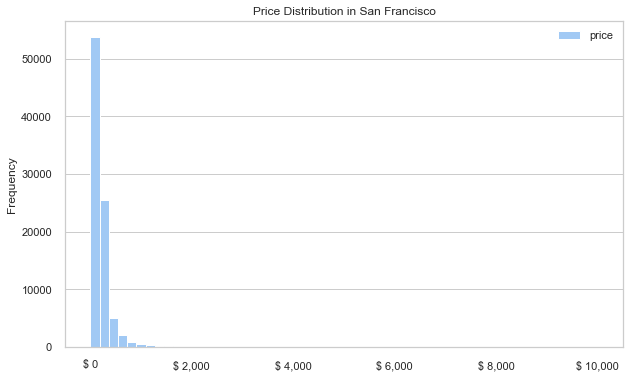

In [99]:
#Airbnb price distributions
listings.price.plot(kind = 'hist', bins=55,  title='Price Distribution in San Francisco',
          legend = True, figsize=(10,6));

#Get axis object
ax = plt.gca()

#Format X axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,}".format(int(x))))

#Mute grid lines
ax.grid(b=False, which ='major', axis = 'x')

In [100]:
print(listings.shape)

(88937, 66)


In [101]:
#Calculate IQR of price
q25 = listings['price'].quantile(0.25)
q75= listings['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in listings.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in listings.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
listings = listings[listings.price.isin(outliers_removed)]
listings.shape

Percentiles: 25th=100.000, 75th=240.000 
IQR= 140.000
Number of outliers identified: 8989
Non-outlier observations: 79948


(79948, 66)

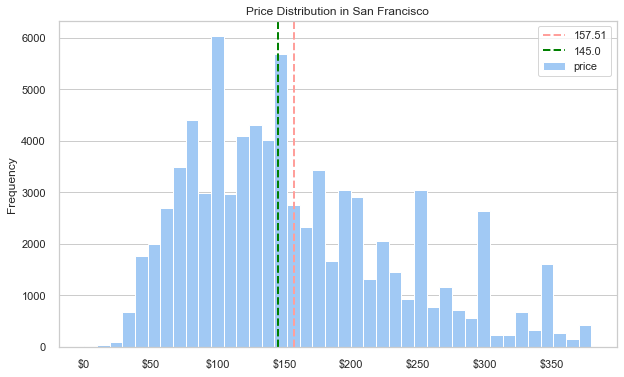

In [102]:
#Airbnb price distributions(outliers removed)
listings.price.plot(kind = 'hist', bins=40,  title='Price Distribution in San Francisco',
           figsize=(10,6));

#Capture mean and median of price
mean = listings.price.mean()
median = listings.price.median()

#Plot mean and median
plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))
plt.axvline(median, color='green',linewidth=2, linestyle='--', label= str(median))

#Get axis object
ax = plt.gca()

#Format X axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Mute grid lines
plt.grid(b=False, which ='major', axis = 'x')

plt.legend(loc='upper right',frameon=True, fancybox=True)


**Zillow Data**

**Preview**

In [103]:
zillow.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,10025,New York,NY,New York-Newark-Jersey City,New York County,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.760586,4.759262,4.728369,4.649493,4.596234,4.502814,4.502814,4.563172,4.520492,4.602169,4.579187,4.602689,4.758883,4.744174,4.745006,4.642857,4.724614,4.770642,4.789450,4.717837,4.756390,4.796840,4.872180,4.815970,4.817292,4.849345,4.855790,4.888889,4.884319,4.759740,4.844890,4.856264,4.859764,4.823151,4.781519,4.867596,4.759262,4.856264,4.918033,4.818314,4.855385,4.828151,4.838579,4.822749,4.855385,4.830588,4.849885,4.857143,4.857143,4.882515,4.857143,4.854432,4.622773,4.589812,4.635174,4.690432,4.684397,4.712362,4.602169,4.709948,4.727273,4.741379,4.845303,4.742853,4.759641,4.791667,4.795833,4.758883,4.778213,4.736781,4.715447,4.759262,4.791667
1,10023,New York,NY,New York-Newark-Jersey City,New York County,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.008538,5.124417,5.196000,5.222104,5.289532,5.214286,5.287183,5.351145,5.500000,5.457552,5.460993,5.489614,5.494807,5.452559,5.460993,5.435646,5.393258,5.393258,5.447224,5.503583,5.500000,5.579632,5.524117,5.477952,5.476451,5.563282,5.563282,5.500000,5.494505,5.500000,5.460993,5.411255,5.412726,5.416667,5.376368,5.352941,5.337687,5.268537,5.064457,5.419075,5.417603,5.376368,5.502809,5.522388,5.459016,5.459016,5.439298,5.371179,5.410414,5.343034,5.343034,5.376368,5.131064,5.073684,5.230769,5.311114,5.369653,5.333333,5.189338,5.203851,5.344029,5.460993,5.352941,5.376368,5.244338,5.239365,5.354893,5.376368,5.341643,5.341246,5.393519,5.333333,5.328199
2,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.935449,0.949539,0.914634,0.903023,0.93551,1.004149,0.982043,0.915948,0.925001,0.928813,0.916289,0.920132,0.919619,0.922917,0.924884,0.940018,0.927235,0.914495,0.914704,0.892230,0.882240,0.907391,0.911686,0.906612,0.910931,0.921464,0.908444,0.923444,0.928412,0.910273,0.902669,0.895347,0.900558,0.902935,0.889328,0.886767,0.874514,0.877414,0.882297,0.889248,0.873744,0.860832,0.832552,0.814220,0.840034,0.829738,0.830119,0.842235,0.845590,0.844415,0.860166,0.874172,0.859759,0.850277,0.857796,0.862350,0.887784,0.894855,0.883838,0.879405,0.878774,0.888325,0.893187,0.873730,0.859788,0.850462,0.838218,0.843280,0.847439,0.871108,0.859599,0.878735,0.876373,0.875818,0.869565,0.878677,0.869986,0.865801,0.859745,0.865134
3,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.643087,0.682688,0.704924,0.662983,0.67897,0.708128,0.714286,0.708128,0.700219,0.683587,0.688707,0.701772,0.695128,0.702634,0.730035,0.698563,0.688073,0.719346,0.717828,0.6983

Convert zillow data into a tidy dataset

In [104]:
#Set columns for melt
id_vars = list(zillow.loc[:,:'SizeRank'].columns.values)
value_vars = list(zillow.iloc[:,6:].columns.values)

#Melt zillow. Create a Data and Price/SqrFt column
zillow = zillow.melt(id_vars= id_vars,value_vars= value_vars, var_name='Date', value_name= 'Price/SqrFt' )

Capture Zillow data pertaining to data in listings data

In [105]:
#Capture zip information from listings
listings_zip = list(listings.zipcode.unique())

#Capture city information from listings 
listings_cities = ['Brisbane', 'Daly City', 'San Francisco', 'South San Francisco']

#Capture SF Data
sf_zillow = zillow[zillow['RegionName'].isin(listings_zip) | zillow['City'].isin(listings_cities)]

#Check
sf_zillow

,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price/SqrFt
7,94109,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,8,2010-02,NaN
68,94110,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,69,2010-02,NaN
423,94080,South San Francisco,CA,San Francisco-Oakland-Hayward,San Mateo County,424,2010-02,NaN
451,94112,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,452,2010-02,NaN
538,94015,Daly City,CA,San Francisco-Oakland-Hayward,San Mateo County,539,2010-02,NaN
...,...,...,...,...,...,...,...,...
386906,94123,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,1555,2019-10,4.808244
387200,94131,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,1849,2019-10,3.846154
387604,94510,Benicia,CA,Vallejo-Fairfield,Solano County,2253,2019-10,1.954972
388326,94105,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,2975,2019-10,5.211640


### Review Data

In [106]:
#View shape
print('Reviews data shape:',reviews.shape,end= '\n\n')


Reviews data shape: (430766, 6)



## Calendar Data

In [107]:
#Original calendar shape
print('Original calendar shape:', calendar.shape)

calendar.dtypes

Original calendar shape: (15901917, 7)


adjusted_price           float64
available                  int64
date              datetime64[ns]
listing_id                 int64
maximum_nights           float64
minimum_nights           float64
price                    float64
dtype: object

In [108]:
calendar.head(2)

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,80.0,0,2019-04-03,187730,120.0,3.0,80.0
1,80.0,0,2019-04-04,187730,120.0,3.0,80.0


### Remove Duplicate Rows